In [ ]:
# implementing feed forward neural style transfer with miniai 

In [3]:
%%capture
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install --pre timm

In [94]:
import os
import random
import shutil
from glob import glob
from pathlib import Path

import fastcore.all as fc
import numpy as np
import timm
import torch
import torch.nn as nn
from miniai.conv import def_device
from miniai.datasets import DataLoaders, get_dls, show_image, show_images
from miniai.learner import *
from torch import tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.io import ImageReadMode, read_image


In [9]:
MS_COCO_2014_URL = "http://images.cocodataset.org/zips/train2014.zip"

IMAGENET_MEAN_1 = tensor([0.485, 0.456, 0.406])
IMAGENET_STD_1 = tensor([0.229, 0.224, 0.225])


In [10]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

'cuda'

In [65]:
# style image
style_url = "https://jkoushik.me/neural-style/imgs/style/fulls/stained_glass.jpg"

style_path = Path("style_images")
style_path.mkdir(exist_ok=True)

style_image_path = fc.urlsave(style_url, style_path)
style_img = read_image(str(style_image_path), mode=ImageReadMode.RGB) / 255

<Axes: >

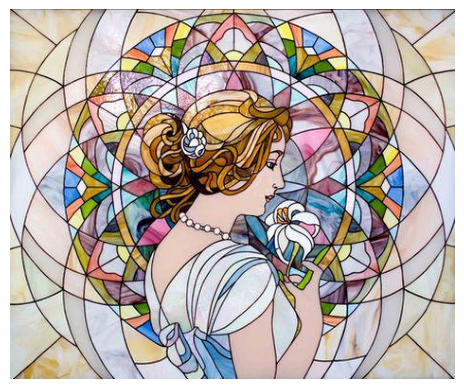

In [66]:
show_image(style_img)

In [ ]:
data_path = Path("ms_coco")
data_path.mkdir(exist_ok=True)
path_zip = fc.urlsave(MS_COCO_2014_URL, data_path)
shutil.unpack_archive(data_path / "train2014.zip", data_path / "data")

In [68]:
image_path = Path("/content/ms_coco/data/train2014")
images = glob(str(image_path / "**/*.jpg"), recursive=True)

In [69]:
images[:10]

['/content/ms_coco/data/train2014/COCO_train2014_000000182782.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000505949.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000296614.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000308575.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000044569.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000121454.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000079077.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000007650.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000230833.jpg',
 '/content/ms_coco/data/train2014/COCO_train2014_000000463805.jpg']

In [95]:
BS = 8

NUM_TRAIN_IMG = BS * 2000
VAL_RATIO = 0.20

total = int(NUM_TRAIN_IMG + NUM_TRAIN_IMG * VAL_RATIO)
sampled = random.sample(images, total)

train_images = sampled[:NUM_TRAIN_IMG]
val_images = sampled[NUM_TRAIN_IMG:]

len(train_images), len(val_images)


(16000, 3200)

In [96]:
class TinyDS:
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB) / 255
        return img


class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop):
        self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item)


def get_the_dls(train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs, **kwargs),
    )


def denorm(x):
    return (x * IMAGENET_STD_1[:, None, None] + IMAGENET_MEAN_1[:, None, None]).clamp(
        0, 1
    )

In [97]:
transform_list = [
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(256),
    transforms.Normalize(mean=IMAGENET_MEAN_1, std=IMAGENET_STD_1),
]
transformz = transforms.Compose(transform_list)

In [98]:
train_ds = TinyDS(train_images)
val_ds = TinyDS(val_images)

tfm_tds = TfmDS(train_ds, tfmx=transformz)
tfm_vds = TfmDS(val_ds, tfmx=transformz)

dls = DataLoaders(*get_the_dls(tfm_tds, tfm_vds, bs=BS, num_workers=0, drop_last=True))

In [99]:
nxb = next(iter(dls.train))

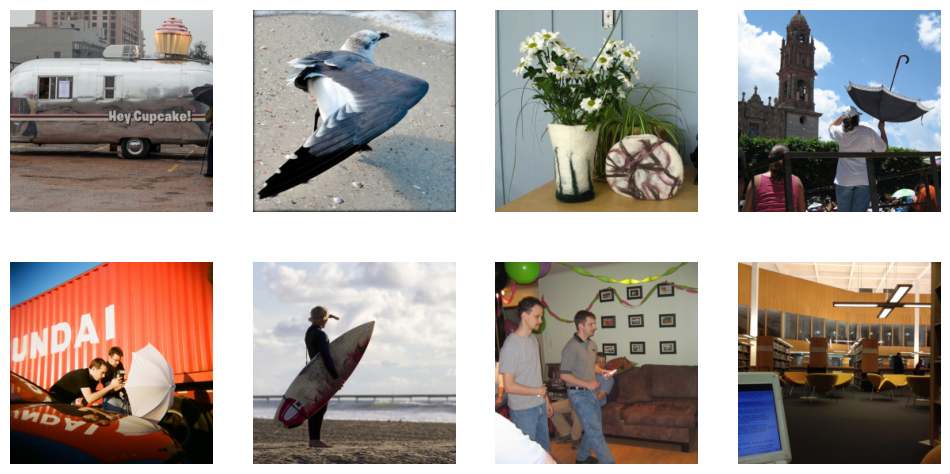

In [100]:
show_images(denorm(nxb))

In [101]:
vgg16 = timm.create_model("vgg16", pretrained=True).to(device).features

_ = vgg16.eval()

for param in vgg16.parameters():
    param.requires_grad = False

In [102]:
# via https://github.com/pytorch/examples/blob/main/fast_neural_style/neural_style/transformer_net.py


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(
                x_in, mode="nearest", scale_factor=self.upsample
            )
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [103]:
# TODO: init weights properly
style_transfer_model = TransformerNet().train().to(device)


In [109]:
# TODO: this can be done maybe nicer with the Hooks class
def calc_features(x, target_layers=(8,)):
    feats = []
    for i, layer in enumerate(vgg16[: max(target_layers) + 1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats


def gram_matrix(x):
    return torch.einsum("bchw, bdhw -> bcd", x, x) / torch.prod(
        torch.tensor(x.size()[1:])
    )


class StyleLoss:
    def __init__(
        self,
        style_image,
        style_weight=3e5,
        content_weight=1e0,
        style_target_layers=(3, 8, 15, 22),
    ):
        fc.store_attr()
        raw_style_features = calc_features(
            style_image, self.style_target_layers
        )

        self.style_features = [
            gram_matrix(x) for x in raw_style_features
        ]

    def __call__(self, batch: torch.Tensor, preds: torch.Tensor):
        # content
        raw_batch_features = calc_features(batch)
        raw_pred_features = calc_features(preds, self.style_target_layers)

        content_loss = torch.nn.MSELoss()(
            raw_batch_features[0], raw_pred_features[1]
        )
        content_loss *= self.content_weight

        # style
        style_loss = 0.0
        pred_features = [
            gram_matrix(x) for x in raw_pred_features
        ]
        for tsr, csr in zip(
            self.style_features, pred_features
        ):
            style_loss += torch.nn.MSELoss()(tsr, csr)

        style_loss /= len(self.style_features)
        style_loss *= self.style_weight

        return content_loss + style_loss

In [110]:
style_transforms = [transforms.Normalize(mean=IMAGENET_MEAN_1, std=IMAGENET_STD_1)]
transform = transforms.Compose(style_transforms)
style_im = transform(style_img).to(device)
style_im = style_im.repeat(BS, 1, 1, 1)

In [112]:
style_loss = StyleLoss(style_im)


In [114]:
epochs = 3
learning_rate = 0.001


class NSTTrainCB(TrainCB):
    def predict(self, learn):
        learn.preds = learn.model(learn.batch)

    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.batch, learn.preds)


cbs = [
    NSTTrainCB(),
    DeviceCB(),
    ProgressCB(plot=True),
    MetricsCB(),
]

learn = Learner(
    style_transfer_model,
    dls,
    style_loss,
    lr=learning_rate,
    cbs=cbs,
    opt_func=torch.optim.Adam,
)

In [ ]:
learn.fit(epochs)

In [135]:
torch.save(learn.model, "ff_nst_stained_glass.pkl")

In [129]:
content_url = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"

content_path = Path("content_images")
content_path.mkdir(exist_ok=True)

content_image_path = fc.urlsave(content_url, content_path)
content_img = read_image(str(content_image_path), mode=ImageReadMode.RGB) / 255

<Axes: >

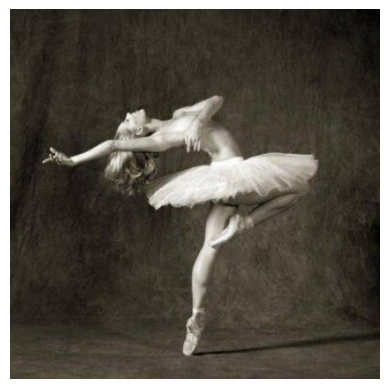

In [130]:
show_image(content_img)

In [131]:
transform_list = [transforms.Normalize(mean=IMAGENET_MEAN_1, std=IMAGENET_STD_1)]
transformz = transforms.Compose(transform_list)

infer_dtype = torch.float16
content_im = transformz(content_img).to(device=device)
content_im = content_im.repeat(1, 1, 1, 1)

In [132]:
_ = learn.model.eval()


In [133]:
with torch.no_grad():
    pred = learn.model(content_im)


<Axes: >

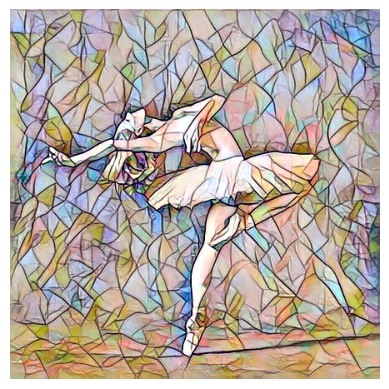

In [134]:
show_image(denorm(pred.squeeze().to("cpu")))